# Self-Adaptation

In [1]:
pip install cma -q


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cma

# ----- Benchmark functions -----

def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    x = np.array(x)
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))

In [3]:
def one_plus_one_es_classic(fitness_function, N=10, sigma=0.5, max_generations=1000):
    x = np.random.uniform(-5, 5, N)
    history = []

    for _ in range(max_generations):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        print(fitness_function(x))
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
        history.append(fitness_function(x))
        sigma*=0.99

    return x, history


for f in [sphere]:
    x_best, history = one_plus_one_es_classic(f)
    print(f.__name__, "Best fitness:", history[-1])

109.06965664908054
109.06965664908054
109.06965664908054
109.06965664908054
109.06965664908054
109.06965664908054
107.38483590787625
102.38558283741808
99.39657025629734
97.1188177867634
97.1188177867634
97.1188177867634
90.21170902543378
90.21170902543378
90.21170902543378
90.21170902543378
90.21170902543378
90.21170902543378
90.21170902543378
90.21170902543378
87.09151210548752
87.09151210548752
87.09151210548752
87.09151210548752
84.6425525698538
84.6425525698538
84.6425525698538
79.41166365440465
78.30312918613615
72.00891748922709
72.00891748922709
72.00891748922709
72.00891748922709
72.00891748922709
68.48756846586996
63.54552432112113
62.08734265858303
59.61042080433201
59.61042080433201
55.80744475356533
55.80744475356533
48.50078071868412
40.921352871454076
40.921352871454076
40.24577224383369
38.95468949588746
38.95468949588746
38.95468949588746
38.95468949588746
38.368906841380834
38.368906841380834
38.368906841380834
35.15535831151684
35.15535831151684
35.15535831151684
35.

In [4]:
def one_plus_one_es_success_rule(fitness_function, N=10, sigma=0.5, max_generations=2000):
    x = np.random.uniform(-5, 5, N)
    tau = 1.5
    k = 20
    success_count = 0
    history = []

    for t in range(1, max_generations + 1):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
            success_count += 1

        if t % k == 0:
            success_rate = success_count / k
            if success_rate > 1/5:
                sigma *= tau
            else:
                sigma /= tau
            success_count = 0

        history.append(fitness_function(x))

    return x, history


for f in [sphere, rastrigin]:
    x_best, history = one_plus_one_es_success_rule(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 1.7178193175235595e-21
rastrigin Best fitness: 37.808302700523186


In [5]:
def mu_plus_lambda_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200, sigma=0.3):
    population = np.random.randn(mu, dim)
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            parent = population[np.random.randint(mu)]
            child = parent + sigma * np.random.randn(dim)
            offspring.append(child)

        combined = np.vstack([population, offspring])
        fitness = np.array([fitness_fn(ind) for ind in combined])
        best_indices = np.argsort(fitness)[:mu]
        population = combined[best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = mu_plus_lambda_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.13758965858164823
rastrigin Best fitness: 22.646589027557212


In [6]:
def self_adaptive_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200):
    tau = 1 / np.sqrt(dim)
    population = [(np.random.randn(dim), 0.5) for _ in range(mu)]
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            x, sigma = population[np.random.randint(mu)]
            sigma_prime = sigma * np.exp(tau * np.random.randn())
            sigma_prime = max(sigma_prime, 1e-8)
            x_prime = x + sigma_prime * np.random.randn(dim)
            offspring.append((x_prime, sigma_prime))

        combined = population + offspring
        fitness = [fitness_fn(ind[0]) for ind in combined]
        best_indices = np.argsort(fitness)[:mu]
        population = [combined[i] for i in best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = self_adaptive_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 3.143729930685946e-16
rastrigin Best fitness: 8.954626476020636


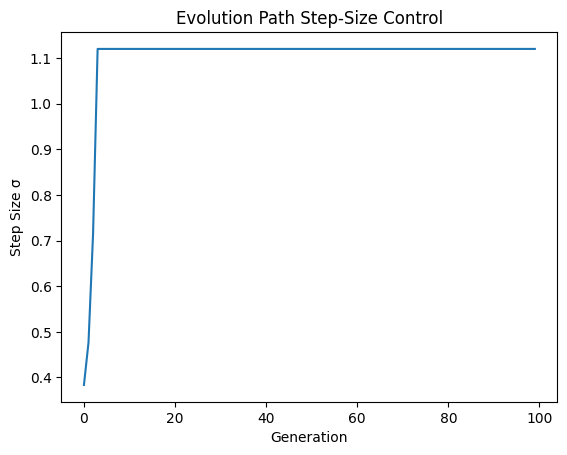

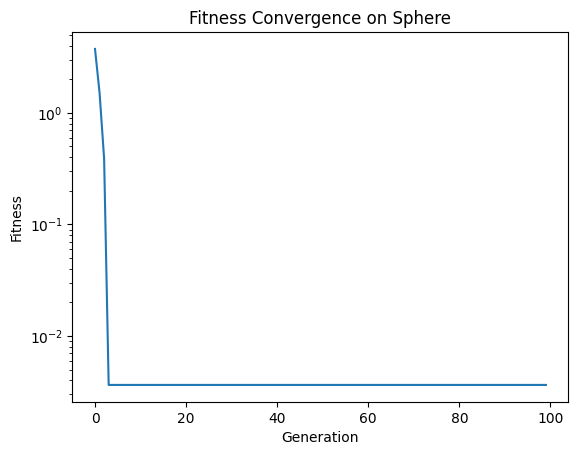

In [7]:
def evolution_path_es(generations=100):
    x = 2.0
    sigma = 0.5
    p_sigma = 0.0
    c_sigma = 0.3
    d_sigma = 1.0
    expected_norm = np.sqrt(2/np.pi)

    sigma_vals = []
    fitness_vals = []

    for _ in range(generations):
        z = np.random.randn()
        x_candidate = x + sigma * z

        # Elitist selection
        if sphere(x_candidate) < sphere(x):
            x = x_candidate
            p_sigma = (1 - c_sigma) * p_sigma + np.sqrt(c_sigma*(2-c_sigma)) * z
            sigma *= np.exp((c_sigma/d_sigma) * (abs(p_sigma)/expected_norm - 1))

        sigma_vals.append(sigma)
        fitness_vals.append(sphere(x))

    return sigma_vals, fitness_vals

sigma_vals, fitness_vals = evolution_path_es()

# Plot step size
plt.figure()
plt.plot(sigma_vals)
plt.xlabel("Generation")
plt.ylabel("Step Size σ")
plt.title("Evolution Path Step-Size Control")
plt.show()

# Plot fitness (log scale)
plt.figure()
plt.plot(fitness_vals)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.yscale("log")
plt.title("Fitness Convergence on Sphere")
plt.show()

In [8]:
def simple_cma_es(fitness_fn, N=10, sigma=0.5, lambda_=10, mu=5, generations=200):
    x = np.random.randn(N)
    C = np.eye(N)
    history = []

    for _ in range(generations):
        A = np.linalg.cholesky(C)
        Z = np.random.randn(lambda_, N)
        X = x + sigma * Z @ A.T
        fitnesses = np.array([fitness_fn(xi) for xi in X])
        indices = np.argsort(fitnesses)
        selected = X[indices[:mu]]
        x_mean = np.mean(selected, axis=0)

        C_update = np.zeros((N,N))
        for xi in selected:
            diff = xi - x_mean
            C_update += np.outer(diff, diff)
        C = 0.8*C + 0.2*(C_update/mu)

        if fitness_fn(x_mean) <= fitness_fn(x):
            x = x_mean

        history.append(fitness_fn(x))

    return x, history


for f in [sphere, rastrigin]:
    best, history = simple_cma_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 4.234343202541698e-15
rastrigin Best fitness: 11.939499170973477


In [9]:
def run_pycma(fitness_fn):
    N = 10
    initial_mean = np.random.randn(N)
    initial_sigma = 0.5

    es = cma.CMAEvolutionStrategy(initial_mean, initial_sigma)
    es.optimize(fitness_fn, maxfun=10000)
    print("Best fitness:", es.result.fbest)

print("Sphere:")
run_pycma(sphere)

print("\nRastrigin:")
run_pycma(rastrigin)

Sphere:
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=126317, Wed Feb 25 09:44:44 2026)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]


    1     10 7.932381418451089e+00 1.0e+00 4.71e-01  5e-01  5e-01 0:00.0
    2     20 7.302316856479797e+00 1.2e+00 4.40e-01  4e-01  4e-01 0:00.0
    3     30 4.590359119447691e+00 1.2e+00 4.36e-01  4e-01  4e-01 0:00.0
  100   1000 5.063708880762527e-06 2.0e+00 1.71e-03  7e-04  8e-04 0:00.0
  200   2000 8.847486262978675e-13 2.2e+00 1.23e-06  2e-07  3e-07 0:00.1
  222   2220 9.131425023275119e-15 2.0e+00 2.89e-07  4e-08  5e-08 0:00.1
termination on {'tolfun': 1e-11}
final/bestever f-value = 9.131425e-15 9.131425e-15 after 2220/2216 evaluations
incumbent solution: [-8.35974577e-09  6.09635438e-09  1.35616520e-08 -1.54943998e-08
 -1.89450321e-08  7.61551506e-09  1.61779045e-08  5.14226595e-08 ...]
std deviations: [4.10097441e-08 4.67680736e-08 3.78939431e-08 4.91535960e-08
 4.23099650e-08 4.41425088e-08 4.55150314e-08 3.58357829e-08 ...]
Best fitness: 9.131425023275119e-15

Rastrigin:
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=143996, Wed Feb 25 09:44:44 2026)
Iterat #Feva

# EXERCISES 3 (a)(b)(c)

  n=  2  μ=5  λ=20  final fitness: 4.224e-24 ± 3.013e-24
  n= 10  μ=5  λ=40  final fitness: 1.206e-20 ± 2.876e-21
  n=100  μ=50  λ=400  final fitness: 1.295e-15 ± 9.173e-16


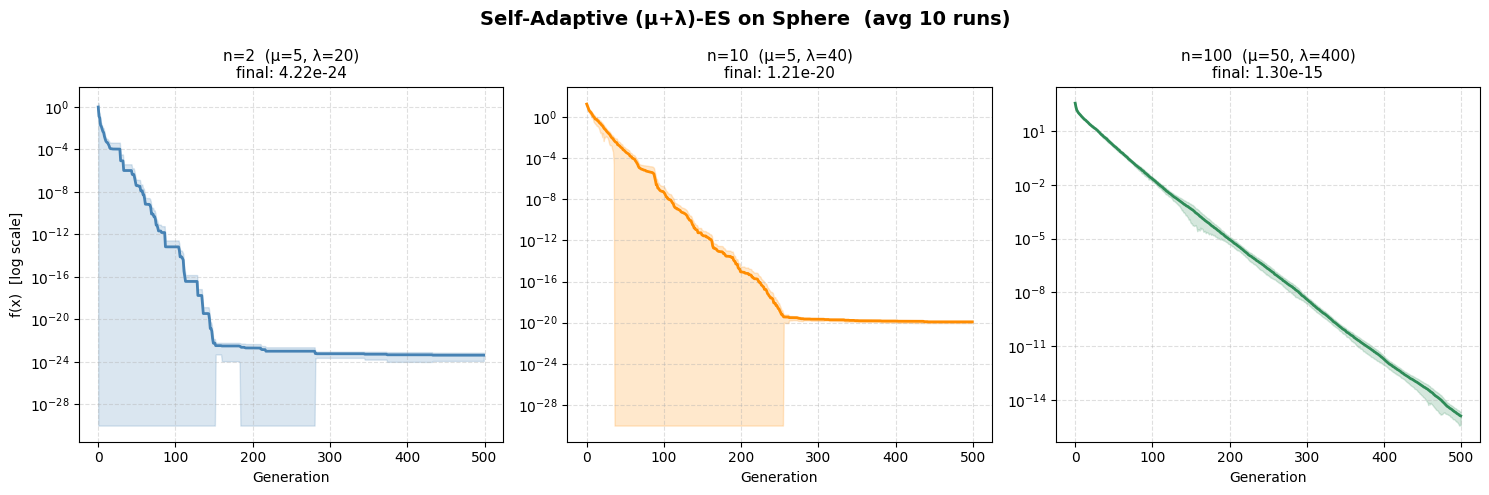

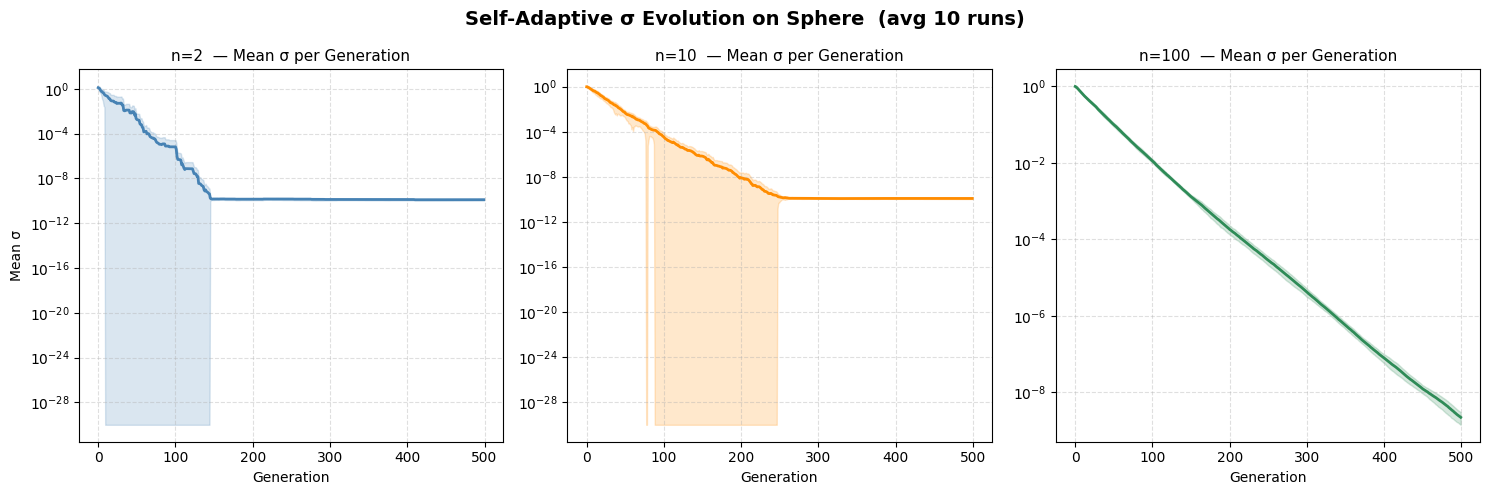

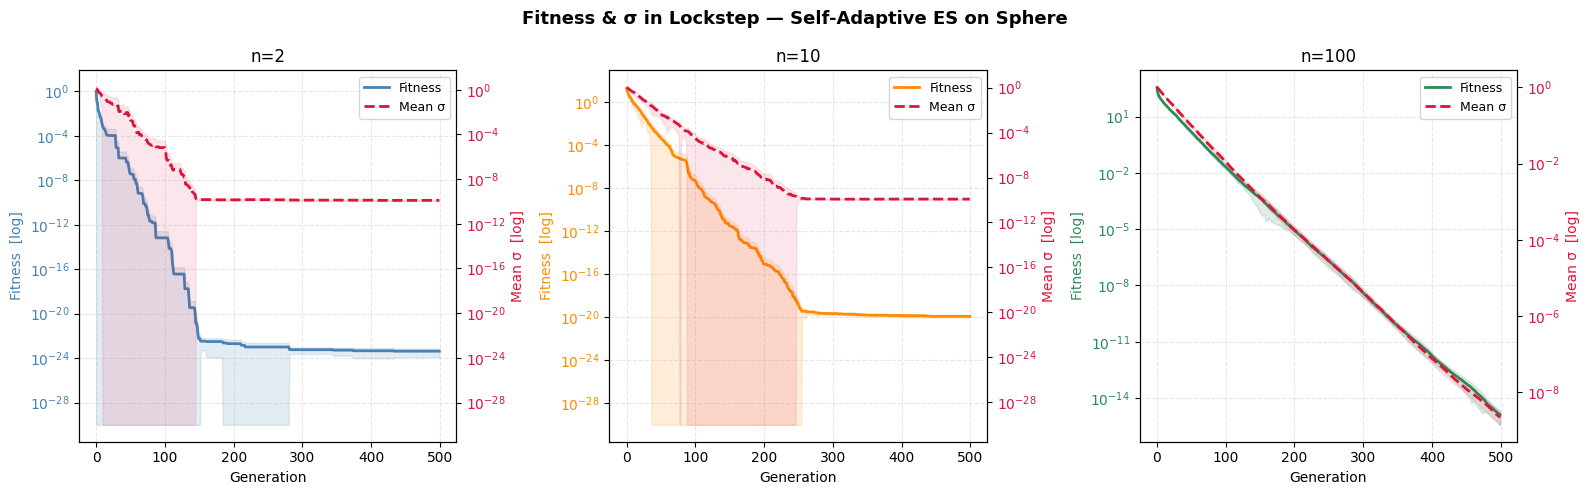


     n      μ      λ    Final Fitness (mean)    Final σ (mean)
     2      5     20            4.223714e-24      1.255833e-10
    10      5     40            1.205832e-20      1.201996e-10
   100     50    400            1.295483e-15      2.200974e-09


In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec

# benchmark 
def sphere(x):
    return np.sum(x**2)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ── Benchmark ──────────────────────────────────────────────────────────────────
def sphere(x):
    return np.sum(x**2)

def mu_plus_lambda_es_fixed(fitness_fn, dim=10, mu=5, lmbda=20,
                             generations=300, sigma=0.3,
                             recombination="intermediate", selection="plus"):
    if selection == "comma" and lmbda < mu:
        raise ValueError(f"Comma selection requires lmbda ({lmbda}) >= mu ({mu})")

    population = np.random.uniform(-5, 5, (mu, dim))
    history = []
    for _ in range(generations):
        offspring = np.array([
            _recombine(population, recombination) + sigma * np.random.randn(dim)
            for _ in range(lmbda)
        ])
        pool      = np.vstack([population, offspring]) if selection == "plus" else offspring
        fitnesses = np.array([fitness_fn(ind) for ind in pool])
        idx       = np.argsort(fitnesses)[:mu]
        population = pool[idx]
        history.append(fitnesses[idx[0]])
    return population[0], history

def _recombine(parents, mode):
    p1 = parents[np.random.randint(len(parents))]
    p2 = parents[np.random.randint(len(parents))]
    if mode == "intermediate":
        return 0.5 * (p1 + p2)
    mask = np.random.rand(len(p1)) < 0.5
    return np.where(mask, p1, p2)

# (a)  
def self_adaptive_es(fitness_fn, dim=10, mu=15, lmbda=100,
                     generations=500, sigma_init=1.0):
    tau_global = 1.0 / np.sqrt(2 * dim)
    tau_local  = 1.0 / np.sqrt(2 * np.sqrt(dim))
    sigma_min  = 1e-10    
    population = [
        (np.random.uniform(-5, 5, dim),
         np.full(dim, sigma_init))
        for _ in range(mu)
    ]
    fitness_history = []
    sigma_history   = []   
    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            idx1, idx2   = np.random.randint(mu, size=2)
            x1, s1 = population[idx1]
            x2, s2 = population[idx2]
            x_child     = 0.5 * (x1 + x2)   
            sigma_child = 0.5 * (s1 + s2)   
            global_noise = np.random.randn()                   
            local_noise  = np.random.randn(dim)                
            sigma_child  = sigma_child * np.exp(
                tau_global * global_noise + tau_local * local_noise
            )
            sigma_child  = np.maximum(sigma_child, sigma_min)  
            x_child = x_child + sigma_child * np.random.randn(dim)
            offspring.append((x_child, sigma_child))
        combined  = population + offspring
        fitnesses = np.array([fitness_fn(ind[0]) for ind in combined])
        best_idx  = np.argsort(fitnesses)[:mu]
        population = [combined[i] for i in best_idx]
        fitness_history.append(fitnesses[best_idx[0]])
        mean_sigma = np.mean([ind[1] for ind in population])
        sigma_history.append(mean_sigma)
    best_x, best_sigma = population[0]
    return best_x, best_sigma, fitness_history, sigma_history

# (b) 
DIMS     = [2, 10, 100]
N_RUNS   = 10
GENS     = 500

def get_mu_lambda(dim):
    mu    = max(5,  dim // 2)
    lmbda = max(20, dim * 4)
    return mu, lmbda
np.random.seed(42)
all_results = {}   
for dim in DIMS:
    mu, lmbda = get_mu_lambda(dim)
    fh_runs, sh_runs = [], []
    for run in range(N_RUNS):
        _, _, fh, sh = self_adaptive_es(sphere, dim=dim, mu=mu, lmbda=lmbda,
                                         generations=GENS, sigma_init=1.0)
        fh_runs.append(fh)
        sh_runs.append([np.mean(s) for s in sh])  
    fh_arr = np.array(fh_runs)
    sh_arr = np.array(sh_runs)
    all_results[dim] = (fh_arr.mean(0), fh_arr.std(0),
                        sh_arr.mean(0), sh_arr.std(0))
    print(f"  n={dim:>3}  μ={mu}  λ={lmbda}  final fitness: {fh_arr[:,-1].mean():.3e} ± {fh_arr[:,-1].std():.3e}")


# (c) 
dim_colors = {2: "steelblue", 10: "darkorange", 100: "seagreen"}

# fig 1 - fit curv
fig = plt.figure(figsize=(15, 5))
fig.suptitle(f"Self-Adaptive (μ+λ)-ES on Sphere  (avg {N_RUNS} runs)",
             fontsize=14, fontweight="bold")

gens = np.arange(GENS)
for i, dim in enumerate(DIMS):
    ax = fig.add_subplot(1, 3, i + 1)
    mean_f, std_f, _, _ = all_results[dim]
    mu, lmbda = get_mu_lambda(dim)

    ax.semilogy(gens, mean_f, color=dim_colors[dim], linewidth=2)
    ax.fill_between(gens,
                    np.maximum(mean_f - std_f, 1e-30),
                    mean_f + std_f,
                    alpha=0.2, color=dim_colors[dim])
    ax.set_title(f"n={dim}  (μ={mu}, λ={lmbda})\nfinal: {mean_f[-1]:.2e}",
                 fontsize=11)
    ax.set_xlabel("Generation")
    ax.set_ylabel("f(x)  [log scale]" if i == 0 else "")
    ax.grid(True, which="both", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
plt.close()

# fig 2 - σ curves 
fig = plt.figure(figsize=(15, 5))
fig.suptitle(f"Self-Adaptive σ Evolution on Sphere  (avg {N_RUNS} runs)",
             fontsize=14, fontweight="bold")
for i, dim in enumerate(DIMS):
    ax = fig.add_subplot(1, 3, i + 1)
    _, _, mean_s, std_s = all_results[dim]
    ax.plot(gens, mean_s, color=dim_colors[dim], linewidth=2)
    ax.fill_between(gens,
                    np.maximum(mean_s - std_s, 1e-30),
                    mean_s + std_s,
                    alpha=0.2, color=dim_colors[dim])
    ax.set_title(f"n={dim}  — Mean σ per Generation", fontsize=11)
    ax.set_xlabel("Generation")
    ax.set_ylabel("Mean σ" if i == 0 else "")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
plt.close()

# fig 3: combined fit + σ on same axes 
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Fitness & σ in Lockstep — Self-Adaptive ES on Sphere",
             fontsize=13, fontweight="bold")
for ax, dim in zip(axes, DIMS):
    mean_f, std_f, mean_s, std_s = all_results[dim]
    color_f = dim_colors[dim]
    color_s = "crimson"
    ax2 = ax.twinx()   
    lf, = ax.semilogy(gens, mean_f, color=color_f, linewidth=2, label="Fitness")
    ax.fill_between(gens,
                    np.maximum(mean_f - std_f, 1e-30),
                    mean_f + std_f,
                    alpha=0.15, color=color_f)

    ls, = ax2.semilogy(gens, mean_s, color=color_s, linewidth=2,
                       linestyle="--", label="Mean σ")
    ax2.fill_between(gens,
                     np.maximum(mean_s - std_s, 1e-30),
                     mean_s + std_s,
                     alpha=0.1, color=color_s)
    ax.set_title(f"n={dim}", fontsize=12)
    ax.set_xlabel("Generation")
    ax.set_ylabel("Fitness  [log]", color=color_f)
    ax2.set_ylabel("Mean σ  [log]", color=color_s)
    ax.tick_params(axis="y", labelcolor=color_f)
    ax2.tick_params(axis="y", labelcolor=color_s)
    ax.grid(True, which="both", linestyle="--", alpha=0.3)
    ax.legend(handles=[lf, ls], loc="upper right", fontsize=9)

plt.tight_layout()
plt.show()
plt.close()

print("\n" + "=" * 60)
print(f"{'n':>6}  {'μ':>5}  {'λ':>5}  {'Final Fitness (mean)':>22}  {'Final σ (mean)':>16}")
print("=" * 60)
for dim in DIMS:
    mu, lmbda = get_mu_lambda(dim)
    mean_f, std_f, mean_s, std_s = all_results[dim]
    print(f"{dim:>6}  {mu:>5}  {lmbda:>5}  {mean_f[-1]:>22.6e}  {mean_s[-1]:>16.6e}")
print("=" * 60)